# Monte Carlo Dropout on Transfomers

In this notebook we use Monte Carlo Dropout [Gal, Ghahramani, 2016](https://arxiv.org/pdf/1506.02142.pdf) on RoBERTa-large models trained in the original utilitaianism dataset of [Hendycks et. al, 2021](https://arxiv.org/abs/2008.02275), as well as on our reformulated version of it, to obtain certainty estimates of the models predictions

# Setup

####For Colab only

Set path root folder after change directory command

In [ ]:
# # mount google drive
#from google.colab import drive
#drive.mount('/content/drive')

# # change to directory containing relevant files
#%cd INSERT DIRECTORY

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1g3JCgH-awK6a0hTXlBoIT3NgyxvgLv_M/NLP_CW2/github


In [ ]:
#@title Run to check we're in the correct directory

#try:
  #  f = open("check_directory.txt")
  #  print('Success :)')
#except IOError:
 #   print("Wrong directory, please try again")

Success :)


In [ ]:
!pip install transformers
!pip install barbar

     |████████████████████████████████| 2.3MB 2.9MB/s 
     |████████████████████████████████| 3.3MB 19.0MB/s 
     |████████████████████████████████| 901kB 32.5MB/s 


In [ ]:
import numpy as np
import pandas as pd
import torch
import pickle
from torch.utils.data import TensorDataset, DataLoader
from barbar import Bar

import matplotlib
import matplotlib.pyplot as plt

from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoConfig, AdamW
import os

## Args

A class needed to specify the model and the training parameters we use (lr, epochs...)

In [ ]:
class MyArgs:
  def __init__(self, model, ngpus, weight_decay=0.01, learning_rate=2e-5, nepochs=2, batch_size=16, max_length=64,
               nruns=1):
    self.model = model
    self.ngpus = ngpus
    self.weight_decay = weight_decay
    self.learning_rate = learning_rate
    self.nepochs = nepochs
    self.batch_size = batch_size
    self.max_length = max_length
    self.nruns = nruns

args = MyArgs(model='roberta-large', ngpus=1)

# Loading models for the original and reformulated datasets

### Functions

Source: [https://github.com/hendrycks/ethics](https://github.com/hendrycks/ethics)

In [ ]:
def load_model(args, load_path=None, cache_dir=None):
    if cache_dir is not None:
        config = AutoConfig.from_pretrained(args.model, num_labels=1, cache_dir=cache_dir)
    else:
        config = AutoConfig.from_pretrained(args.model, num_labels=1)
    model = AutoModelForSequenceClassification.from_pretrained(args.model, config=config)
    if load_path is not None:
        model.load_state_dict(torch.load(load_path), strict=False)

    model.cuda()
    model = torch.nn.DataParallel(model, device_ids=[i for i in range(args.ngpus)])

    print('\nPretrained model "{}" loaded'.format(args.model))
    no_decay = ['bias', 'LayerNorm.weight']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in model.named_parameters()
                    if not any(nd in n for nd in no_decay)],
         'weight_decay': args.weight_decay},
        {'params': [p for n, p in model.named_parameters()
                    if any(nd in n for nd in no_decay)],
         'weight_decay': 0.0}
    ]
    optimizer = AdamW(optimizer_grouped_parameters, lr=args.learning_rate, eps=1e-8)

    return model, optimizer

## Code

In [ ]:
!pip install gdown
import gdown
!gdown https://drive.google.com/uc?id=1MHvSFbHjvzebib90wW378VtDAtn1WVxc
!gdown https://drive.google.com/uc?id=1-Y19ljB76eESM6m8EVcZVeQjRfcNa7In

Downloading...
From: https://drive.google.com/uc?id=1MHvSFbHjvzebib90wW378VtDAtn1WVxc
To: /content/drive/.shortcut-targets-by-id/1g3JCgH-awK6a0hTXlBoIT3NgyxvgLv_M/NLP_CW2/github/util_roberta-large.pt
1.43GB [00:15, 93.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-Y19ljB76eESM6m8EVcZVeQjRfcNa7In
To: /content/drive/.shortcut-targets-by-id/1g3JCgH-awK6a0hTXlBoIT3NgyxvgLv_M/NLP_CW2/github/final_rerelease_roberta-large_1e-05_16_2.pkl
1.42GB [00:16, 85.1MB/s]


In [ ]:
model_original, optimizer = load_model(args, load_path='util_roberta-large.pt')
model_rerelease, optimizer = load_model(args, load_path='final_rerelease_roberta-large_1e-05_16_2.pkl')

Some weights of the model checkpoint at roberta-large were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'roberta.pooler.dense.bias', 'lm_head.dense.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.out_proj.bias', 'classi


Pretrained model "roberta-large" loaded


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'roberta.pooler.dense.bias', 'lm_head.dense.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.out_proj.bias', 'classi


Pretrained model "roberta-large" loaded


# Loading data

## Functions

Source: [https://github.com/hendrycks/ethics](https://github.com/hendrycks/ethics)

In [ ]:
def load_process_data(args, data_dir, dataset, name="train"):
    load_fn = load_util_sentences
    sentences, labels = load_fn(data_dir, name=name)
    sentences = ["[CLS] " + s for s in sentences]
    tokenizer = get_tokenizer(args.model)
    ids, amasks = get_ids_mask(sentences, tokenizer, args.max_length)
    within_bounds = [ids[i, -1] == 0 for i in range(len(ids))]
    if np.mean(within_bounds) < 1:
        print("{} fraction of examples within context window ({} tokens): {:.3f}".format(name, args.max_length, np.mean(within_bounds)))
    inputs, labels, masks = torch.tensor(ids), torch.tensor(labels), torch.tensor(amasks)

    even_mask = [i for i in range(inputs.shape[0]) if i % 2 == 0]
    odd_mask = [i for i in range(inputs.shape[0]) if i % 2 == 1]
    even_inputs, odd_inputs = inputs[even_mask], inputs[odd_mask]
    even_labels, odd_labels = labels[even_mask], labels[odd_mask]
    even_masks, odd_masks = masks[even_mask], masks[odd_mask]
    inputs = torch.stack([even_inputs, odd_inputs], axis=1)
    labels = torch.stack([even_labels, odd_labels], axis=1)
    masks = torch.stack([even_masks, odd_masks], axis=1)

    data = TensorDataset(inputs, masks, labels)
    return data

In [ ]:
def load_util_sentences(data_dir, name="train"):
    path = os.path.join(data_dir, "{}.csv".format(name))
    df = pd.read_csv(path, header=None)
    sentences = []
    for i in range(df.shape[0]):
        sentences.append(df.iloc[i, 0])
        sentences.append(df.iloc[i, 1])
    labels = [-1 for _ in range(len(sentences))]
    return sentences, labels

In [ ]:
def get_tokenizer(model):
    tokenizer = AutoTokenizer.from_pretrained(model)
    return tokenizer

In [ ]:
def get_ids_mask(sentences, tokenizer, max_length):
    tokenized = [tokenizer.tokenize(s) for s in sentences]
    tokenized = [t[:(max_length - 1)] + ['SEP'] for t in tokenized]

    ids = [tokenizer.convert_tokens_to_ids(t) for t in tokenized]
    ids = np.array([np.pad(i, (0, max_length - len(i)),
                           mode='constant') for i in ids])

    amasks = []
    for seq in ids:
        seq_mask = [float(i > 0) for i in seq]
        amasks.append(seq_mask)
    return ids, amasks

## Code

Original dataset

In [ ]:
data_dir = '1_original_study_datasets'
train_name = "util_train"
test_name = "util_test"
hard_test_name = "util_test_hard"

train_data = load_process_data(args, data_dir, "util", train_name)
test_hard_data = load_process_data(args, data_dir, "util", hard_test_name)
test_data = load_process_data(args, data_dir, "util", test_name)

train_dataloader = DataLoader(train_data, batch_size=args.batch_size // 2, shuffle=True)
test_hard_dataloader = DataLoader(test_hard_data, batch_size=args.batch_size // 2, shuffle=False)
test_dataloader = DataLoader(test_data, batch_size=args.batch_size // 2, shuffle=False)

util_train fraction of examples within context window (64 tokens): 1.000
util_test_hard fraction of examples within context window (64 tokens): 1.000
util_test fraction of examples within context window (64 tokens): 0.999


Reformulated dataset

In [ ]:
data_dir = '4_reformulated_datasets'
train_name = 'util_train_no_test_overlap'
test_name = "util_test_easy_matched"
hard_test_name = "util_test_hard_matched"
unmatched_test_name = "test_combined_unmatched"

train_data = load_process_data(args, data_dir, "util", train_name)
test_hard_data = load_process_data(args, data_dir, "util", hard_test_name)
test_data = load_process_data(args, data_dir, "util", test_name)
test_unmatched_data = load_process_data(args, data_dir, "util", unmatched_test_name)

train_dataloader_reformulated = DataLoader(train_data, batch_size=args.batch_size // 2, shuffle=True)
test_dataloader_reformulated = DataLoader(test_data, batch_size=args.batch_size // 2, shuffle=False)
hard_test_dataloader_reformulated = DataLoader(test_hard_data, batch_size=args.batch_size // 2, shuffle=False)
unmatched_test_dataloader_reformulated = DataLoader(test_unmatched_data, batch_size=args.batch_size // 2, shuffle=False)

util_train_no_test_overlap fraction of examples within context window (64 tokens): 1.000
util_test_hard_matched fraction of examples within context window (64 tokens): 0.999
util_test_easy_matched fraction of examples within context window (64 tokens): 1.000
test_combined_unmatched fraction of examples within context window (64 tokens): 1.000


# MC Dropout

## Functions

In [ ]:
def flatten(tensor):
    tensor = torch.cat([tensor[:, 0], tensor[:, 1]])
    return tensor

def unflatten(tensor):
    tensor = torch.stack([tensor[:tensor.shape[0] // 2], tensor[tensor.shape[0] // 2:]], axis=1)
    return tensor

def evaluate(model, dataloader):
    model.eval()
    cors = []

    for step, batch in enumerate(dataloader):
        # Copy data to GPU if needed
        batch = tuple(t.cuda() for t in batch)

        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch

        # reshape
        b_input_ids = flatten(b_input_ids)
        b_input_mask = flatten(b_input_mask)

        # Forward pass
        with torch.no_grad():
            output = model(b_input_ids, attention_mask=b_input_mask)[0]  # dim 1
            output = unflatten(output)
            diffs = output[:, 0] - output[:, 1]
            diffs = diffs.squeeze(dim=1).detach().cpu().numpy()
        cors.append(diffs > 0)

    cors = np.concatenate(cors)
    acc = np.mean(cors)

    print('Acc {:.3f}'.format(acc))
    return acc

In [ ]:
def enable_dropout(model):
    """ Function to enable the dropout layers during test-time """
    for m in model.modules():
        if m.__class__.__name__.startswith('Dropout'):
            m.train()

In [ ]:
def MC_dropout(model, dataloader, forward_passes):
    '''
    Inputs:
    - model
    - dataloader
    - forward_passes: int

    Ouputs:
    - predictions: numpy.ndarray, (num_samples,)
    - confidence: numpy.ndarray, (num_samples,)
    - mean, variance: numpy.ndarray
    - avg_correct_variance, avg_wrong_variance: numpy.float64
    '''

    model.eval()
    enable_dropout(model)

    drop_pred = []

    for step, batch in enumerate(Bar(dataloader)):
        # Copy data to GPU if needed
        # Batch has 3 dimensions: inputs, masks, labels
        batch = tuple(t.cuda() for t in batch)

        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch

        num_samples = b_input_ids.shape[0] # Should be 8

        # reshape
        b_input_ids = flatten(b_input_ids)
        b_input_mask = flatten(b_input_mask)

        dropout_predictions = np.zeros((forward_passes, num_samples))

        # Forward pass
        for i in range(forward_passes):
            with torch.no_grad():
                output = model(b_input_ids, attention_mask=b_input_mask)[0]  # dim 1
                output = unflatten(output)
                diffs = output[:, 0] - output[:, 1]
                diffs = diffs.squeeze(dim=1).detach().cpu().numpy()
            
            correct = diffs > 0
            dropout_predictions[i,:] = correct
        
        drop_pred.append(dropout_predictions)

    drop_pred = np.concatenate(drop_pred, axis=1)

    # Calculating mean and variance across forward passes 
    mean = np.mean(drop_pred, axis=0)
    variance = np.var(drop_pred, axis=0)

    # Finding the variance for the instances that were correctly and wrongly classified
    correct_variance = variance[mean>=0.5]
    wrong_variance = variance[mean<0.5]

    # Get binary predictions
    predictions = np.copy(mean)
    predictions[mean>=0.5] = 1
    predictions[mean<0.5] = 0

    # Calculate the confidence in each prediction  
    confidence = np.copy(mean)
    confidence[mean<0.5] = 1 - confidence[mean<0.5] # For the instances where we're classifying as 0, the confidence is the opposite

    results = {'predictions': predictions,
          'confidence': confidence,
          'mean': mean,
          'variance': variance,
          'avg_correct_variance': np.mean(correct_variance),
          'avg_wrong_variance': np.mean(wrong_variance)}

    return results

In [ ]:
def split_in_bins(predictions, confidence):
    num_bins = 5
    l = np.linspace(0.5,1,num_bins+1)
    bins = np.linspace(0.5,.9,num_bins)+.05

    conf = []
    acc = []
    num_in_bins = []

    for ind, (lower,upper) in enumerate(zip(l[:-1], l[1:])):
        indxs = np.where((confidence<=upper) & (confidence>lower)) # B_m

        this_bin_pred = predictions[indxs]
        this_bin_conf = confidence[indxs]

        # Get average confidence
        avg_conf = np.mean(this_bin_conf)

        # Get average accuracy
        avg_acc = np.mean(this_bin_pred)
        conf.append(avg_conf)
        acc.append(avg_acc)
        num_in_bins.append(len(this_bin_pred))
    
    return conf, acc, bins, num_in_bins

def get_ECE(confidence, accuracy, num_in_bins):
  '''
  condifence: list of conf(B_m)
  accuracy: list of acc(B_m)

  num_in_bins: number of samples in each bin
  '''
  assert len(confidence) == len(accuracy)

  num_in_bins = np.asarray(num_in_bins)
  n = num_in_bins.sum() # Tot number of samples
  ECE = 0
  for i in range(len(confidence)):
    ECE += (num_in_bins[i]/(n)) * np.abs(accuracy[i] - confidence[i])

  return ECE

def plot_reliability_diagram_rerelease(accuracy_easy, bins_easy, accuracy_hard, bins_hard,accuracy_unmatched, bins_unmatched, figure_file): #accuracy_unmatched, bins_unmatched, figure_file):
    accuracy = (accuracy_easy, accuracy_hard, accuracy_unmatched)
    bins = (bins_easy, bins_hard, bins_unmatched)
    width=0.1
    fig, ax = plt.subplots(figsize=(13,5), nrows=1, ncols=3)
    fig.suptitle("Assessing calibration of model certainty against accuracy\n(Vadam-optimised RoBERTa-large)", fontsize=14, fontweight='bold')
    for i in range(3):
        ax[i].bar(bins[i], accuracy[i], width=width, color='k', edgecolor='black')
        ax[i].plot(np.linspace(0.5,1,6),np.linspace(0.5,1,6),linestyle='--', color='red')
        ax[i].set_ylabel("Accuracy")
        ax[i].set_xlabel("Model certainty")
        if i==0:
            ax[i].set_title("Easy reformulated test dataset")
        if i==1:
            ax[i].set_title("Hard reformulated test dataset")
        if i == 2:
            ax[i].set_title("Unmatched reformulated test dataset")
    fig.tight_layout(rect=[0, 0, 1, 0.90])
    fig.legend(['Perfect certainty','Model certainty'],loc=(0.75,0.15), facecolor="white")
    fig.savefig(figure_file, dpi=250)
    fig.show()

def plot_reliability_diagram_original(accuracy_easy, bins_easy, accuracy_hard, bins_hard, figure_file): #accuracy_unmatched, bins_unmatched, figure_file):
    accuracy = (accuracy_easy, accuracy_hard)
    bins = (bins_easy, bins_hard)
    width=0.1
    fig, ax = plt.subplots(figsize=(8,5), nrows=1, ncols=2)
    #Change the suptitle with each model accordingly
    fig.suptitle("Assessing calibration of model certainty against accuracy\n(Vadam-optimised RoBERTa-large)", fontsize=14, fontweight='bold')
    for i in range(2):
        ax[i].bar(bins[i], accuracy[i], width=width, color='k', edgecolor='black')
        ax[i].plot(np.linspace(0.5,1,6),np.linspace(0.5,1,6),linestyle='--', color='red')
        ax[i].set_ylabel("Accuracy")
        ax[i].set_xlabel("Model certainty")
        if i==0:
            ax[i].set_title("Easy test dataset")
        if i==1:
            ax[i].set_title("Hard test dataset")
    fig.tight_layout(rect=[0, 0, 1, 0.90])
    fig.legend(['Perfect certainty','Model certainty'],loc=(0.75,0.15), facecolor="white")
    fig.savefig(figure_file, dpi=250)
    fig.show()

**Expected Calibration Error**

"Let $B_m$ be the set of indices of samples whose prediction confidence falls intothe interval $I_m= (\frac{m−1}{M},\frac{m}{M}]$"

$$\text{acc}(B_m) = \frac{1}{|B_m|} \sum_{i \in B_m} \mathbf{1}(\hat{y}_i=y_i)$$

$$\text{conf}(B_m) = \frac{1}{|B_m|} \sum_{i \in B_m} \hat{p}_i$$

$$\text{ECE} = \sum_{m=1}^M \frac{|B_m|}{n} |\text{acc}(B_m) - \text{conf}(B_m)|$$

$n$ = number of samples, $M$ equally spaced bins

https://arxiv.org/pdf/1706.04599.pdf

## MC Dropout: RoBERTa large trained and tested in original dataset

In [ ]:
evaluate(model_original, test_hard_dataloader)

Acc 0.629


0.6285112359550562

In [ ]:
MC_results = MC_dropout(model_original, dataloader=test_hard_dataloader, forward_passes=20)

4272/4272: [===============================>] - ETA 0.2s


In [ ]:
evaluate(model_original, test_dataloader)

Acc 0.795


0.7951331114808652

In [ ]:
MC_results_easy = MC_dropout(model_original, dataloader=test_dataloader, forward_passes=20)

4808/4808: [===============================>] - ETA 0.2s


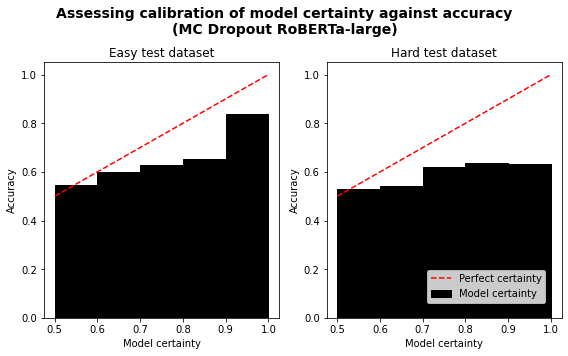

In [ ]:
conf, acc, bins, num_in_bins = split_in_bins(MC_results_easy['predictions'], MC_results_easy['confidence'])
conf_hard, acc_hard, bins_hard, num_in_bins_hard = split_in_bins(MC_results['predictions'], MC_results['confidence'])
ece_easy = get_ECE(conf, acc, num_in_bins)
#print(f"ECE easy test dataset: {ece_easy}")
ece_hard = get_ECE(conf_hard, acc_hard, num_in_bins_hard)
#print(f"ECE hard test dataset: {ece_hard}")
plot_reliability_diagram_original(acc, bins, acc_hard, bins_hard, "mc_dropout_roberta_original_plots")

In [ ]:
print(f"ECE easy test dataset: {ece_easy}")
print(f"ECE hard test dataset: {ece_hard}")


ECE easy test dataset: 0.15305479739659877
ECE hard test dataset: 0.2647770853307766


In [ ]:
accuracy_easy = np.mean(MC_results_easy['predictions'])
print(accuracy_easy)

0.7995008319467554

In [ ]:
accuracy_hard = np.mean(MC_dropout['predictions'])
print(accuracy_hard)

0.6221910112359551

In [ ]:
#Save results
#f = open("mc_dropout_results_roberta_original_hard_test.pkl","wb")
#pickle.dump(MC_results,f)
#f.close()

## MC Dropout: RoBERTa large trained and tested in reformulated dataset

In [ ]:
evaluate(model_rerelease, test_dataloader_reformulated)

Acc 0.976


0.9755371900826446

In [ ]:
MC_results_easy_test_rerelease = MC_dropout(model_rerelease, dataloader=test_dataloader_reformulated, forward_passes=20)

3025/3025: [===============================>] - ETA 0.2s


In [ ]:
#Save results
#f = open("mc_dropout_results_roberta_rerelease_easy_test.pkl","wb")
#pickle.dump(MC_results_easy_test_rerelease,f)
#f.close()

In [ ]:
evaluate(model_rerelease, hard_test_dataloader_reformulated)


Acc 0.727


0.7274323849666315

In [ ]:
MC_results_hard_test_rerelease = MC_dropout(model_rerelease, dataloader=hard_test_dataloader_reformulated, forward_passes=20)

2847/2847: [===============================>] - ETA 0.2s


In [ ]:
#Save results
#f = open("mc_dropout_results_roberta_rerelease_hard_test.pkl","wb")
#pickle.dump(MC_results_hard_test_rerelease,f)
#f.close()

In [ ]:
evaluate(model_rerelease, unmatched_test_dataloader_reformulated)

Acc 0.502


0.5015664160401002

In [ ]:
MC_results_unmatched_test_rerelease = MC_dropout(model_rerelease, dataloader=unmatched_test_dataloader_reformulated, forward_passes=20)

3192/3192: [===============================>] - ETA 0.2s


In [ ]:
#Save results
#f = open("mc_dropout_results_roberta_rerelease_unmatched_test.pkl","wb")
#pickle.dump(MC_results_unmatched_test_rerelease,f)
#f.close()

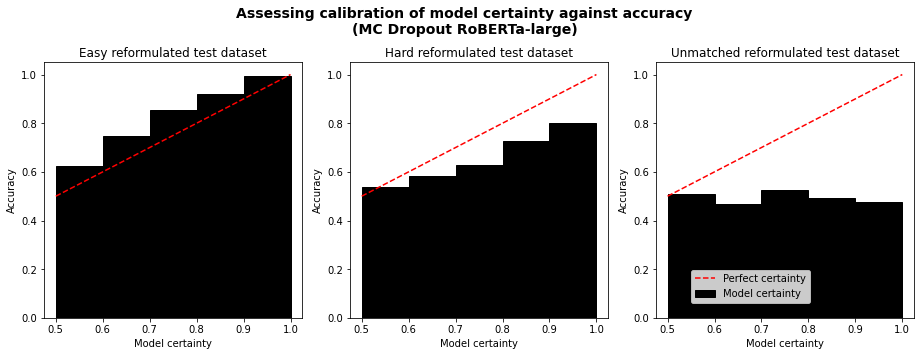

In [ ]:
conf, acc, bins, num_in_bins = split_in_bins(MC_results_easy_test_rerelease['predictions'], MC_results_easy_test_rerelease['confidence'])
conf_hard, acc_hard, bins_hard, num_in_bins_hard = split_in_bins(MC_results_hard_test_rerelease['predictions'], MC_results_hard_test_rerelease['confidence'])
conf_unm, acc_unm, bins_unm, num_in_bins_unm = split_in_bins(MC_results_unmatched_test_rerelease['predictions'], MC_results_unmatched_test_rerelease['confidence'])
ece_easy = get_ECE(conf, acc, num_in_bins)
#print(f"ECE easy test dataset: {ece_easy}")
ece_hard = get_ECE(conf_hard, acc_hard, num_in_bins_hard)
#print(f"ECE hard test dataset: {ece_hard}")
ece_unmatched = get_ECE(conf_unm, acc_unm, num_in_bins_unm)
plot_reliability_diagram(acc, bins, acc_hard, bins_hard, acc_unm, bins_unm, "mc_dropout_roberta_rerelease_plots")
#print(f"ECE unmatched test dataset: {ece_unmatched}")

In [ ]:
print(f"ECE easy test dataset: {ece_easy}")
print(f"ECE hard test dataset: {ece_hard}")
print(f"ECE unmatched test dataset: {ece_unmatched}")

ECE easy test dataset: 0.008073089700996714
ECE hard test dataset: 0.1456993133357426
ECE unmatched test dataset: 0.4046919885094159


In [ ]:
accuracy_easy_test = np.mean(MC_results_easy_test_rerelease['predictions'])
print(accuracy_easy_test)

0.9771900826446281

In [ ]:
accuracy_hard_test = np.mean(MC_results_hard_test_rerelease['predictions'])
print(accuracy_hard_test)

0.7133825079030558

In [ ]:
accuracy_unmatched_test = np.mean(MC_results_unmatched_test_rerelease['predictions'])
print(accuracy_unmatched_test)

0.4956140350877193